# 6. 게이트가 추가된 RNN

4장에서 본 RNN은 순환 경로를 포함해 과거의 정보를 기억할 수 있고, 구조가 단순해 구현도 쉽게 할 수 있었다. 그러나 시계열 데이터에서 시간적으로 멀리 떨어진 장기 의존 관계를 잘 학습하지 못해 성능이 좋지 못하다. 따라서 LSTM이나 GRU가 주로 쓰이며, RNN이라고 하면 LSTM을 의미하는 경우도 흔하다. 

LSTM이나 GRU는 게이트라는 구조가 더해져 있어서 시계열 데이터의 장기 의존 관계를 학습할 수 있다. 

## 6.1.  RNN의 문제점
RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어려운데, 그 원인은 BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문이다. 

> 기울기 소실: 역전파의 기울기 값이 점점 작아지다가 기울기가 는 현상    
기울기 폭발: 기울기가 매우 큰 수가 되는 현상

### 6.1.1 RNN 복습
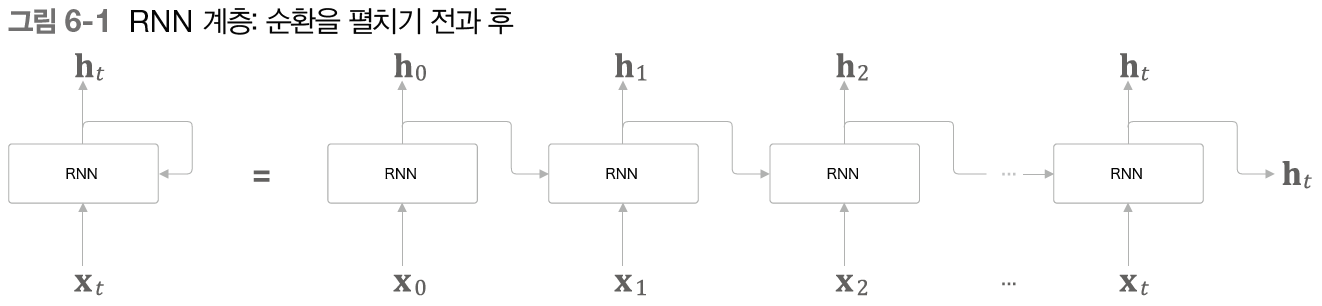
RNN 계층은 순환 경로를 갖고 있다. 시계열 데이터인 $\mathbf x_t$를 입력하면 은닉 상태 $\mathbf h_t$를 출력한다. 은닉 상태는 과거의 정보를 저장한다. RNN의 특징은 이전 시각의 은닉 상태를 이용해 과거의 정보를 계승한다. 

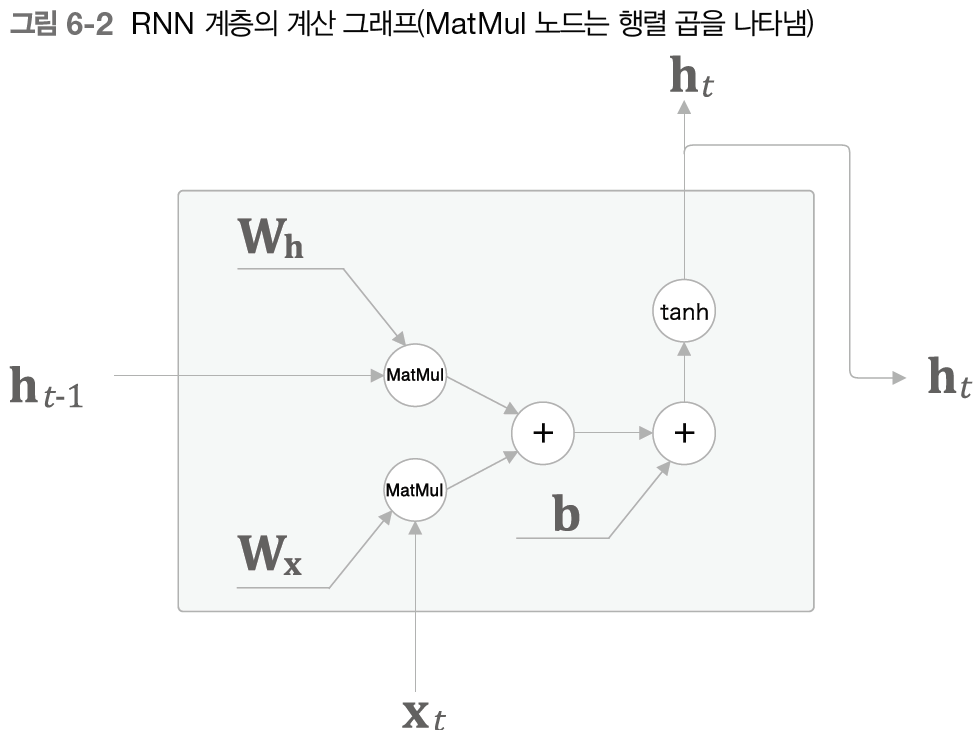

RNN 계층의 순전파에서 수행하는 계산은 행렬의 곱과 합, 활성화 함수 tanh 함수에 의한 변환이다. 

### 6.1.2 기울기 소실 또는 기울기 폭발
언어 모델은 주어진 단어들을 기초로 다음에 출현할 단어를 예측하는 일을 한다. RNN을 사용한 언어모델을 RNNLM라고 한다. 

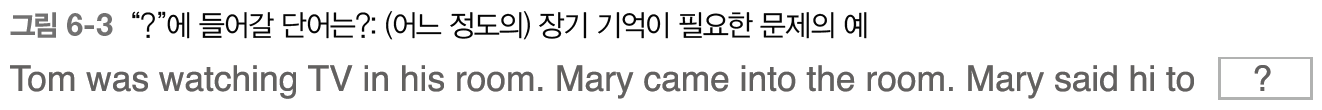

RNNLM이 이 문제에 올바르게 답하려면 현재 맥락에서 "Tom was watching TV in his room."과 "Mary came into the room."란 정보를 RNN 계층의 은닉 상태에 인코딩해 보관해 두어야 한다. 

위의 예를 RNNLM 학습의 관점에서 생각해보자. 정답 레이블로 "Tom"이라는 단어가 주어졌을 때 RNNLM에서의 학습은 BPTT로 수행되며, "Tom"이라고 주어진 시점에서부터 과거 방향으로 기울기를 전달한다. 

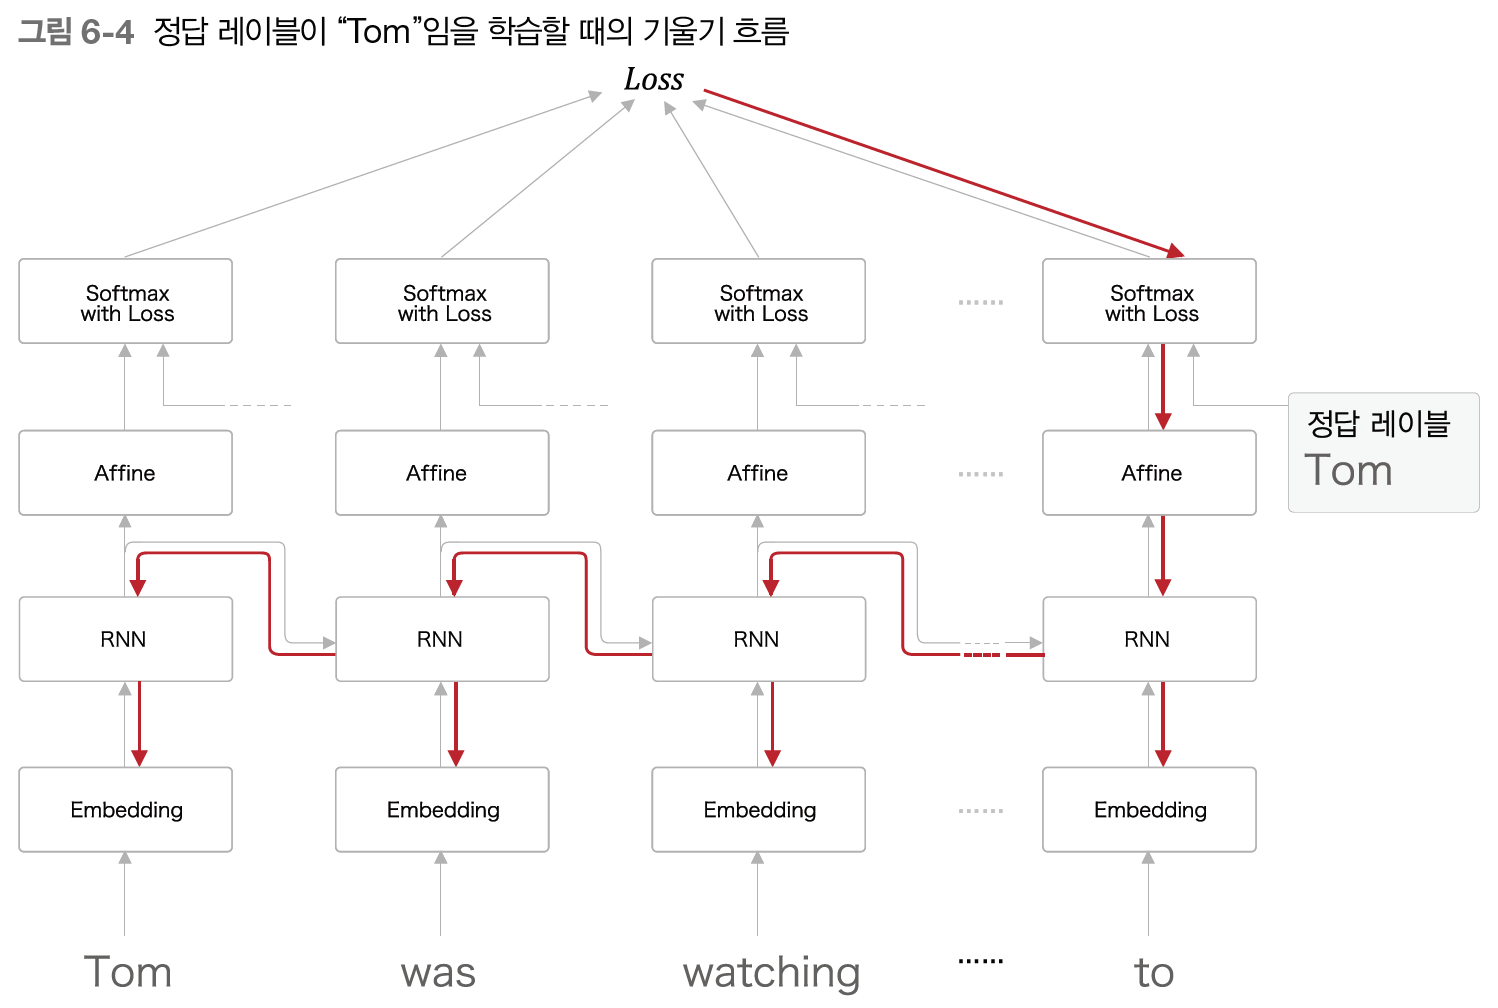

RNN 계층이 과거 방향으로 '의미 있는 기울기'를 전달함으로써 시간 방향의 의존 관계를 학습할 수 있다. 기울기는 학습해야 할 의미가 있는 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습한다. 그러나 만약 이 기울기가 중간에 줄어들면 (정보가 소실되면) 가중치 매개변수는 갱신되지 않는다. 즉 장기 의존 관계를 학습할 수 없다. 그런데 단순한 RNN 계층에서는 과거로 갈수록 기울기가 작아지거나 (기울기 소실) 혹은 커진다. (기울기 폭발)

### 6.1.3 기울기 소실과 기울기 폭발의 원인

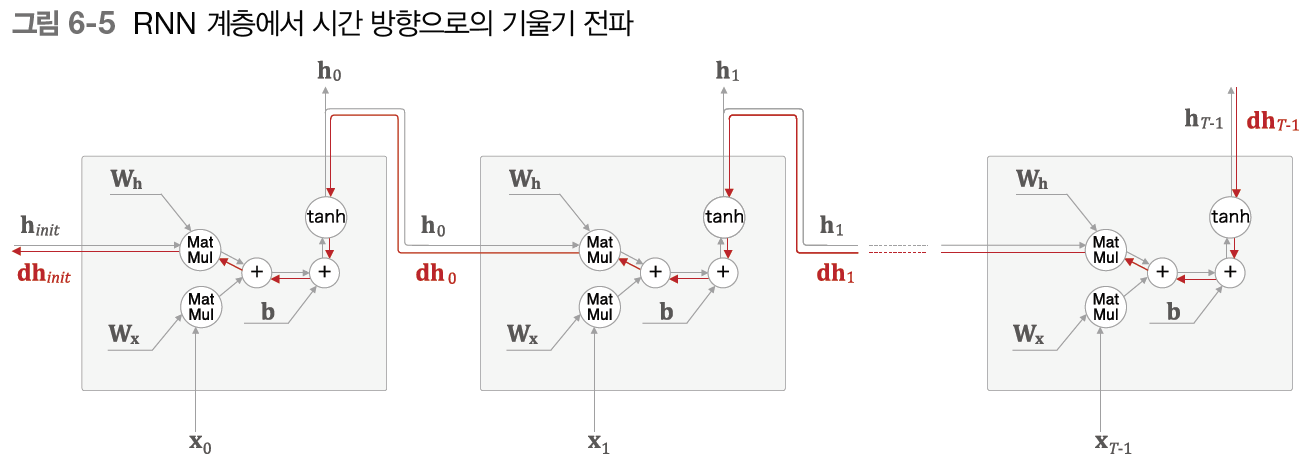

위의 그림처럼 길이가 T인 시계열 데이터를 가정하고, T번째 정답 레이블에서 전해지는 기울기가 어떻게 변하는지 보자. 시간 방향 기울기에 주목하면 역전파로 전해지는 기울기는 차례로 'tanh',  '+', 'MatMul(행렬곱)' 연산을 통과한다. '

- '+'의 역전파    

상류에서 전해지는 기울기를 그대로 전해주므로 기울기는 변화하지 않는다.    
- 'tanh'의 역전파

y=tanh(x)일 때의 미분은 $\frac {\partial y}{\partial x} = 1 - y^2$이다. 

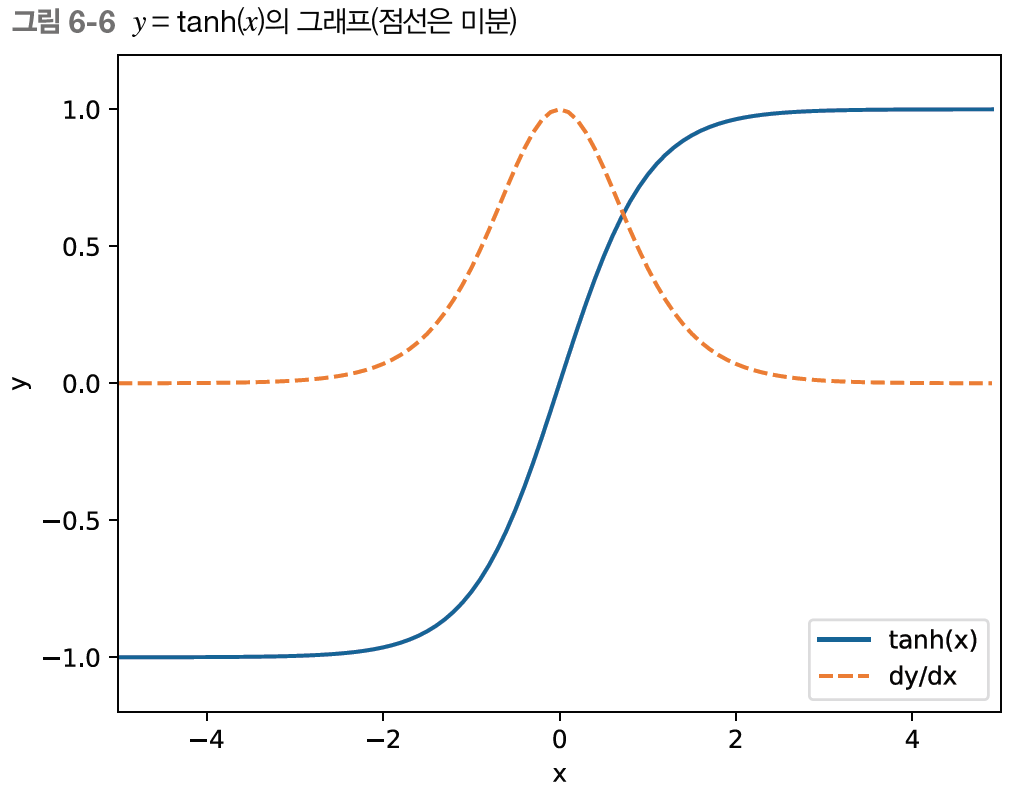

그래프에서 점선이 y=tanh(x)의 미분이며고, 그 값은 1.0 이하이고, x가 0에서 멀어질수록 작아진다. 즉 역전파에서 기울기가 tanh 노드를 지날 때마다 기울기는 계속 작아진다. tanh 함수를 T번 통과하면 기울기도 T번 반복해서 작아진다. 

> RNN 계층의 활성화 함수는 주로 tanh 함수를 사용한다. 그러나 기울기 소실 문제를 해결하기 위해 활성화 함수를 ReLU로 바꾸면 기울기 소실을 줄일 수 있다. (ReLU를 x에 입력하면 max(0, x)를 출력함) ReLU는 입력 x가 0 이상이면 역전파 시 상류의 기울기를 그대로 하류에 흘려보내므로 기울기가 작아지지 않는다. (논문 준재. 'Improving performance of recurrent neural network with relu nonlinearity')

- 'MatMul(행렬곱)'의 역전파

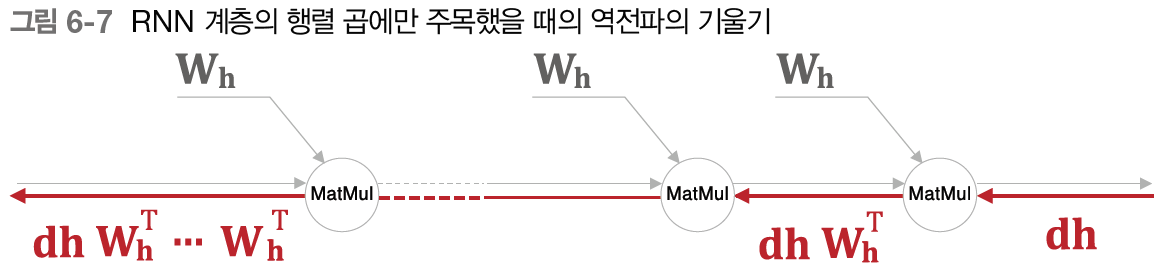

'tanh' 노드를 무시한 후의 행렬곱의 역전파의 계산 그래프이다. 상류로부터 dh라는 기울기가 흘러 들어온다면 MatMul 노드에서의 역전파는 $dhW_h^T$라는 행렬곱으로 기울기를 계산한다. 같은 계산을 시계열 데이터의 시간 크기만큼 반복한다. 주목할 점은 이 행렬 곱셈에서는 매번 같은 가중치인 $W_b$가 사용된다는 것이다.  

In [4]:
import numpy as np
import matplotlib.pyplot as plt

N = 2  # 미니 배치의 크기
H = 3  # 은닉 상태 벡터의 차원 수 
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))   # 초기화, 모든 원소가 1인 행렬 반환
np.random.seed(3)  # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)   # 평균이 0, 표준편차 1인 가우시안 표준 정규분포 난수를 matrix array(H, H)로 생성

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)  # 노드 수 T만큼 dh 갱신
    norm = np.sqrt(np.sum(dh**2)) / N  # L2 노름. np.sum(): 모든 요소의 합 반환
    norm_list.append(norm)

print(norm_list)

[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


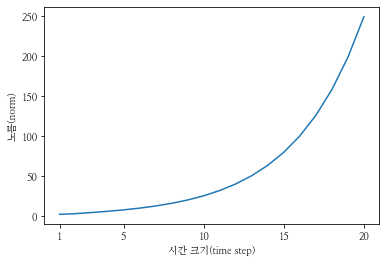

In [14]:
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])  # 눈금, 숫자붙이
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

MatMul 노드를 지날 때마다 기울기는 지수적으로 증가한다. 즉 기울기가 폭발(exploding gradients)이다. 기울기 폭발이 일어나면 오버플로를 일으켜 NaN(Not a Number) 같은 값을 발생시키고 신경망 학습을 제대로 수행할 수 없다. 

만약 Wh의 초깃값을 아래와 같이 변경해보자. 

In [15]:
# Wh의 초깃값 변경

dh = np.ones((N, H))   # 초기화, 모든 원소가 1인 행렬 반환
np.random.seed(3)  # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H) * 0.5  # 평균이 0, 표준편차 1인 가우시안 표준 정규분포 난수를 matrix array(H, H)로 생성

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)  # 노드 수 T만큼 dh 갱신
    norm = np.sqrt(np.sum(dh**2)) / N  # L2 노름. np.sum(): 모든 요소의 합 반환
    norm_list.append(norm)

print(norm_list)

[1.2342034047289652, 0.8339262435402591, 0.5979099219216477, 0.39247420825547574, 0.2525242645318454, 0.16017442237957713, 0.10106299614538981, 0.06358148956166684, 0.03995083909833199, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595105, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571365, 0.0009625497320203265, 0.0006040924319556741, 0.00037912574706291106, 0.00023793756048323344]


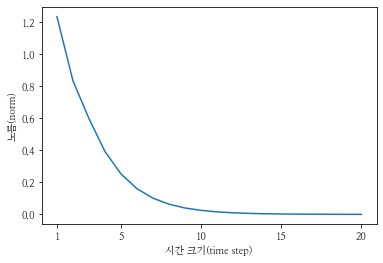

In [16]:
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])  # 눈금, 숫자붙이
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

기울기가 지수적으로 감소하며 이것이 기울기 소멸이다. 기울기 소실이 일어나면 기울기가 매우 빠르게 작아지고, 기울기가 일정 수준 이하로 작아지면 가중치 매개변수가 갱신되지 않으므로 장기 의존 관계를 학습할 수 없다. 

기울기가 지수적으로 증가하거나 감소하는 이유는 행렬 Wh를 T번 반복해서 곱했기 때문이다. 

만약 WH가 스칼라일 경우, Wh가 1보다 크면 기울기는 지수적으로 증가하고, 1보다 작으면 지수적으로 감소한다. WH가 행렬이라면 행렬의 '특잇값'이 척도가 된다. 행렬의 특잇값은 데이터가 얼마나 퍼져 있는지를 나타낸다. 이 특잇값(정확히는 여러 특잇값의 최댓값)이 1보다 큰지 여부를 알면 기울기 크기가 어떻게 변하는지 예측할 수 있다. 

> 특잇값의 최댓값이 1보다 크면 지수적으로 증가하고, 1보다 작으면 지수적으로 감소할 가능성이 높다. 그러나 특잇값이 1보다 크다고 해서 기울기가 반드시 폭발하는 것은 아니다. 

### 6.1.4 기울기 폭발 대책
기울기 폭발의 대책은 전통적인 기법인 기울기 클리핑(Gradients clipping)이 있다. 그 알고리즘을 의사 코드로 쓰면 아래와 같다. 

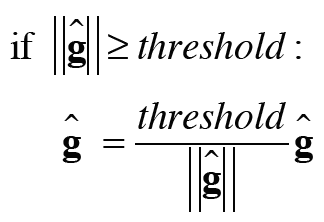

신경망에서 사용되는 모든 매개변수에 대한 기울기를 하나로 처리한다고 가정하고 기호 $\widehat g$(모든 매개변수(예: 가중치 매개변수)에 대한 기울기)로 표기하고, threshold를 문턱값으로 설정했다. 기울기의 L2 노름($\lVert \widehat g \rVert$)이 문턱값을 초과하면 두 번째 줄의 수식과 같이 기울기를 수정한다. 

In [30]:
dW1 = np.random.rand(3,3) * 10  # 0과 1의 균일분포 표준정규분포 난수를 matrix array(3,3)로 생성
dW2 = np.random.rand(3,3) * 10   # 모든 원소에 10을 곱해줌. 원래 원소는 0과 1 사이의 수

grads = [dW1, dW2]
max_norm = 5.0  # threshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


In [24]:
print(grads)

[array([[2.25054505, 4.06519916, 4.68940249],
       [2.69235578, 2.91792774, 4.57686399],
       [8.60533913, 5.86252904, 2.83487862]]), array([[2.77977507, 4.54622076, 2.05410345],
       [2.01378711, 5.1403506 , 0.87229369],
       [4.83585532, 3.62176212, 7.07686622]])]


## 6.2 기울기 소실과 LSTM
기울기 소실 문제를 해결하기 위해 게이트가 추가된 RNN이 등장했다. 대표적인 것이 LSTM과 GRU이다. 

### 6.2.1 LSTM의 인터페이스
앞으로는 행렬 계산 등을 하나의 직사각형 노드로 만드는 식으로 계산 그래프를 단순화한다. 

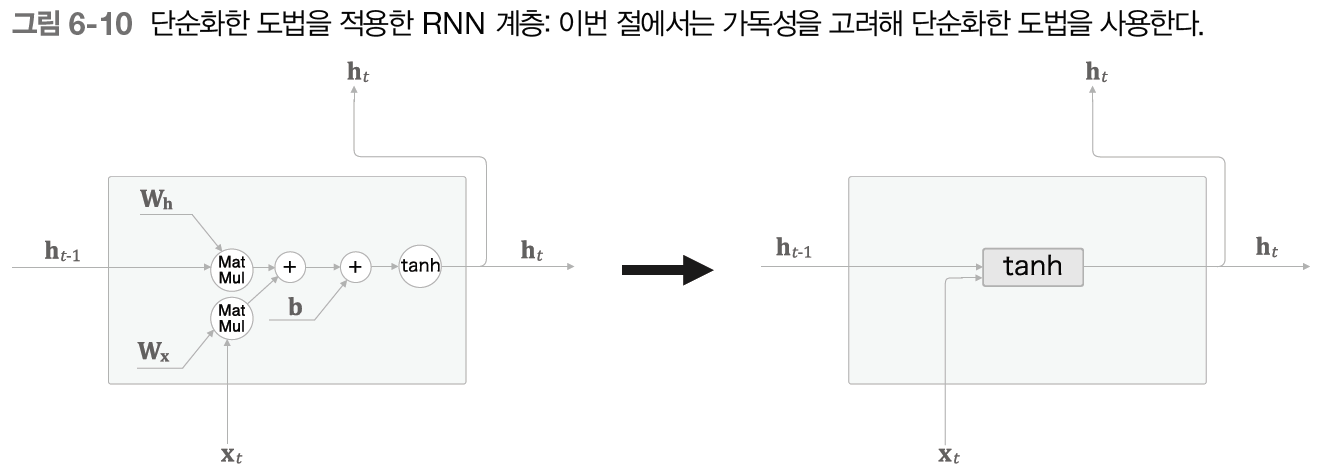

위의 그래프에서는 $tanh(\mathbf{h_{t-1}}\mathbf{W_h} + \mathbf{x_t}\mathbf{W_x} + \mathbf{b})$ 계산을 tanh이라는 직사각형 노드 하나로 그렸다. ($\mathbf{h_{t-1}}$, $\mathbf{x_t}$는 행벡터) 

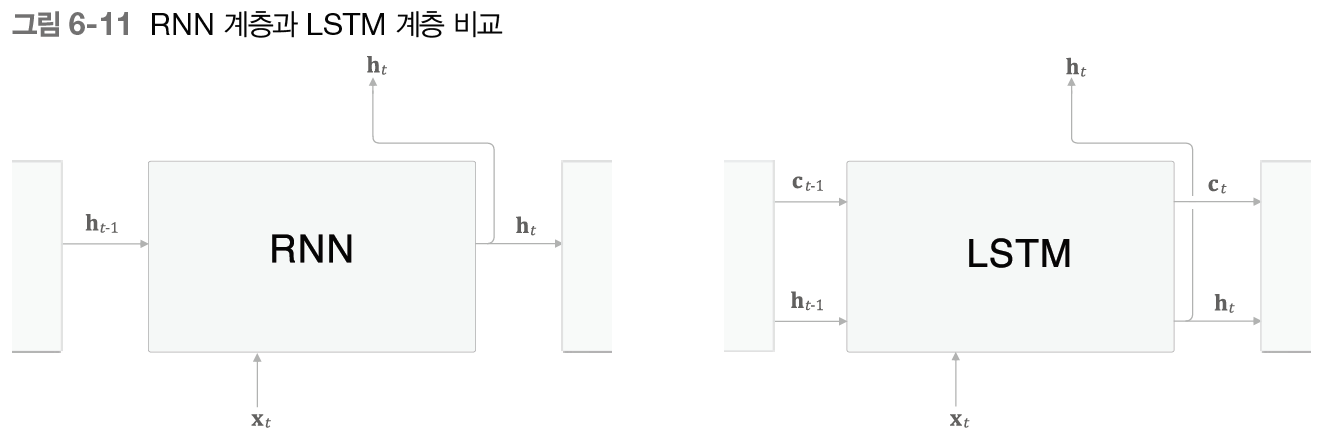

RNN과 달리 LSTM 계층의 인터페이스에는 기억 셀(memory cell) $\mathbf{c}$이 있다. 기억 셀은 LSTM 전용의 기억 메커니즘이다. 기억 셀의 특징은 LSTM 계층 내에서만 완결되고 다른 계층으로는 출력하지 않는다. 반면 LSTM의 은닉 상태 $\mathbf{h}$는 다른 계층(위쪽)으로 출력된다. 

### 6.2.2 LSTM 계층 조립하기
LSTM에는 기억 셀 $\mathbf{c_t}$가 있고, 이 $\mathbf{c_t}$에는 시각 t에서의 LSTM의 기억(과거부터 시각 t까지의 기억)이 저장되어 있다. 필요한 정보를 모두 간직한 이 기억을 바탕으로 외부 계층과 다음 시각의 LSTM에 은닉 상태 $\mathbf{h_t}$를 출력한다. 이 때 출력하는 $\mathbf{h_t}$는 기억 셀의 값을 tanh 함수로 변환한 값이다.

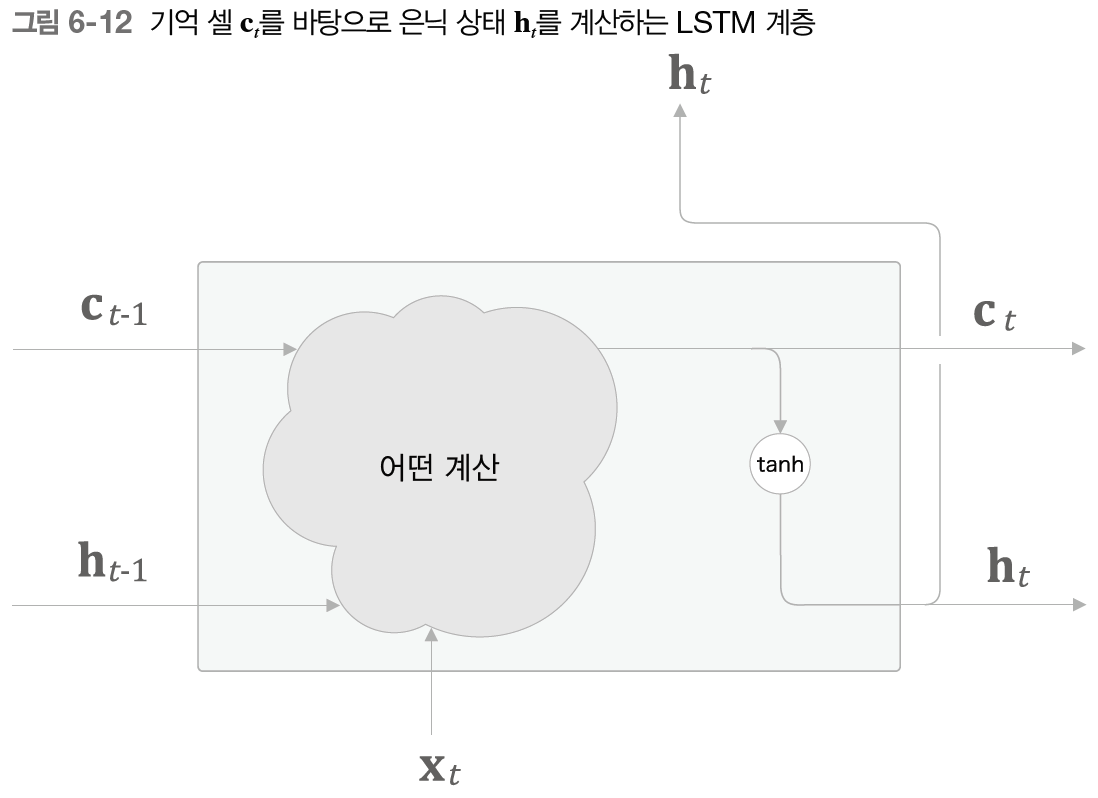

현재의 기억 셀 $\mathbf{c_t}$는 3개의 입력 ($\mathbf{c_{t-1}}, \mathbf{h_{t-1}}, \mathbf{x_t}$)로부터 어떤 계산을 수행해 구할 수 있다. 핵심은 갱신된 $\mathbf{c_t}$를 사용해 은닉 상태 $\mathbf{h_t}$를 계산한다는 것이다. 즉$\mathbf{h_t} = tanh(\mathbf{c_t})$이다. (이 말의 의미는 기억 셀 $\mathbf{c_t}$와 은닉 상태 $\mathbf{h_t}$의 원소 수는 같다는 것이다.)

LSTM에서의 게이트는 다음 단계로 흘려보낼 기억의 양을 제어한다. 게이트의 열림 상태(어느 정도 열지 결정)는 0.0 - 0.1 사이의 실수로 나타낸다. 여기서 중요한 점은 '게이트를 얼마나 열까'도 데이터로부터 (자동으로) 학습한다는 것이다. 

>개이트는 게이트의 열림 상태를 제어하기 위해 전용 가중치 매개변수를 이용하며 이 가중치 매개변수는 학습 데이터로부터 갱신된다. 게이트의 열림 상태를 구할 때는 시그모이드 함수(출력: 0.0 - 1.0)를 사용한다. 

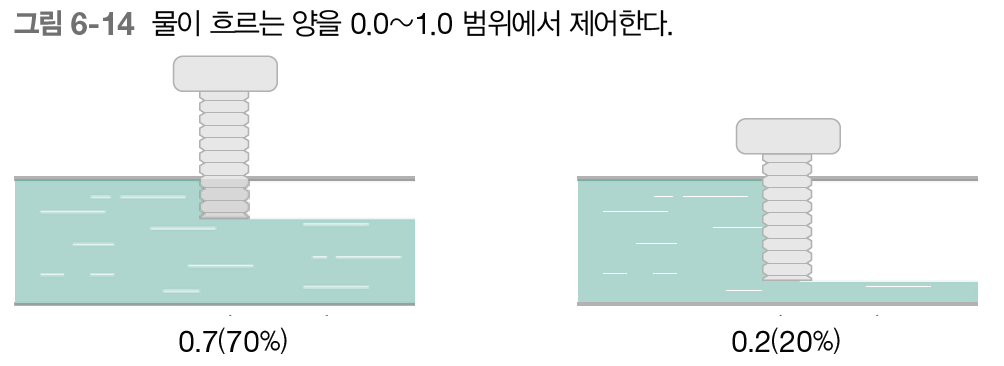

### 6.2.3 output 게이트
$tanh(\mathbf{c_t})$에 적용하는 게이트. $tanh(\mathbf{c_t})$의 각 원소에 대해 '그것이 다음 시각의 은닉 상태에 얼마나 중요한가'를 조정하는 게이트이며, 다음 은닉 상태 $\mathbf{h_t}$의 출력을 담당하는 게이트.

output 게이트의 열림 상태는 입력 $\mathbf{x_{t-1}}$와 이전 은닉 상태 $\mathbf{h_{t-1}}$로부터 구한다. (output 게이트에서 사용하는 가중치 매개변수와 편향에는 o를 첨자로 추가한다. 시그모이드 함수는 $\sigma()$로 표기한다. ) 

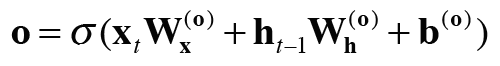

위의 식으로 구한 $\mathbf o$와 $tanh(\mathbf{c_t})$의 원소 곱을 $\mathbf {h_t}$로 출력한다. 

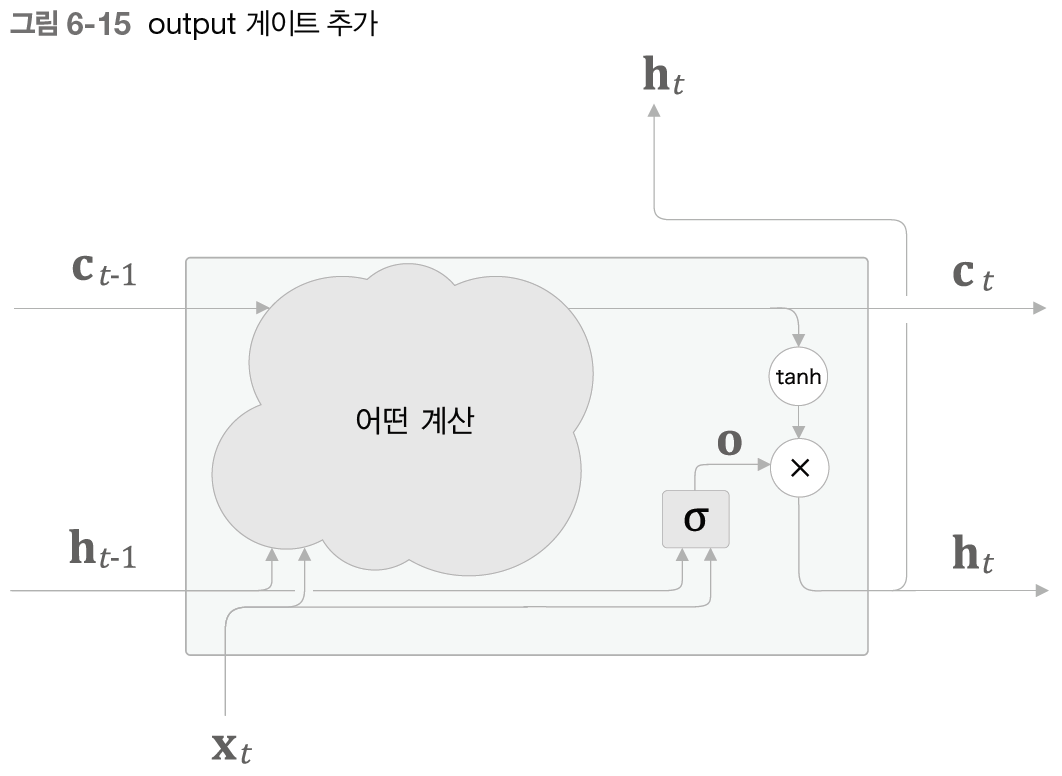

output 게이트에서 수행하는 게산을 $\mathbf \sigma$로 표현한다. 

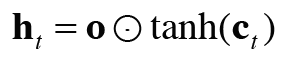

$\mathbf \sigma$의 출력을 $\mathbf o$라고 하면 $\mathbf {h_t}$는 $\mathbf o$와 $tanh(\mathbf{c_t})$의 원소 곱이다. 여기서 '곱'은 원소별 곱이며 이를 아마다르 곱(Hadamard product) $\odot$라고 한다. 

> tanh의 출력은 -1.0 - 1.0의 실수이다. 이 수치는 그 안에 인코딩된 '정보'의 강약(정도)를 표시한다. 시그모이드 함수의 출력은 0.0 - 1.0의 실수이며 데이터를 얼마큼 통과시킬지 정하는 비율이다. 따라서 게이트에서는 시그모이드 함수가, 실질적인 '정보'를 지니는 데이터에는 tanh 함수가 활성화 함수로 사용된다.

### 6.2.4 forget 게이트
$\mathbf{c_{t-1}})$의 기억 중 불필요한 기억을 잊게 해주는 게이트를 forget 게이트라고 한다. 

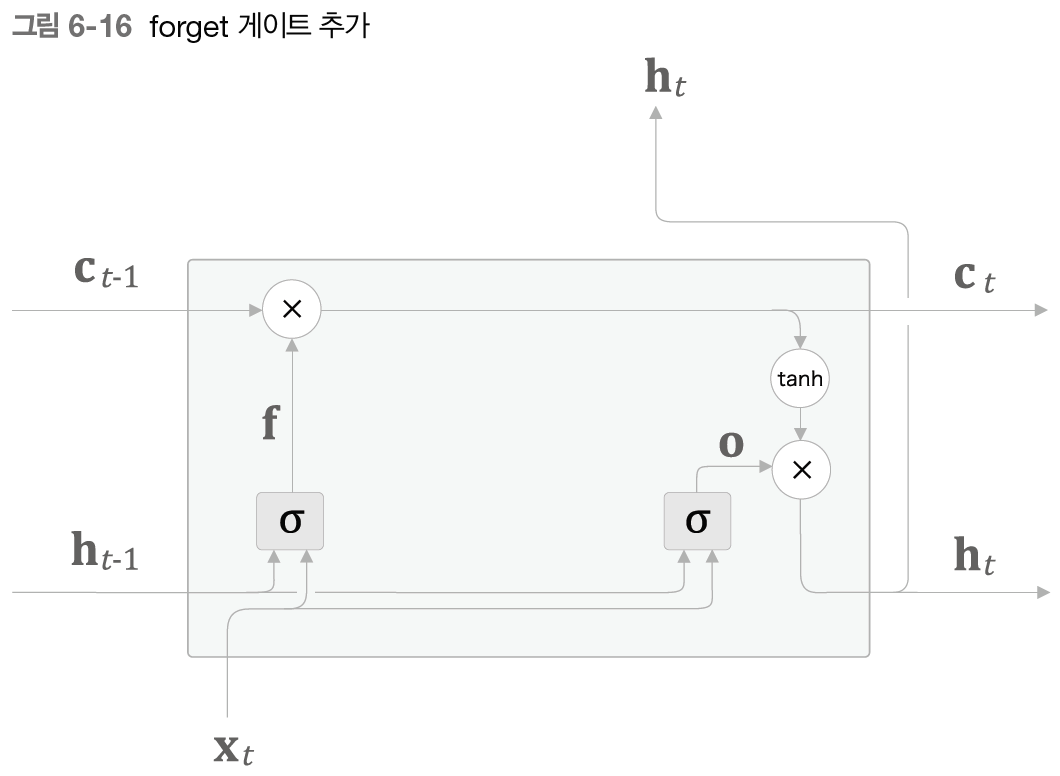

forget 게이트에서 수행하는 게산을 $\mathbf \sigma$로 표현한다. $\mathbf \sigma$ 안에는 forget 게이트 전용의 가중치 매개변수가 있고 다음의 식의 계산을 수행한다.

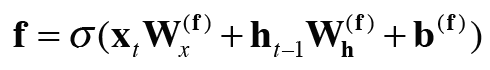

forget 게이트의 출력 $\mathbf f$와 이전 기억 셀인 $\mathbf{c_{t-1}}$과의 원소별 곱을 계산해 $\mathbf{c_{t}}$를 구한다.

$$\mathbf{c_{t}} = \mathbf f \odot\mathbf{c_{t-1}}$$

### 6.2.5 새로운 기억 셀
forget 게이트를 거치면서 이전 시각의 기억 셀로부터 잊어야 할 기억이 삭제되었다. 따라서 새로 기억해야 할 정보를 기억해야 한다. 이를 위해 tanh 노드를 추가한다.

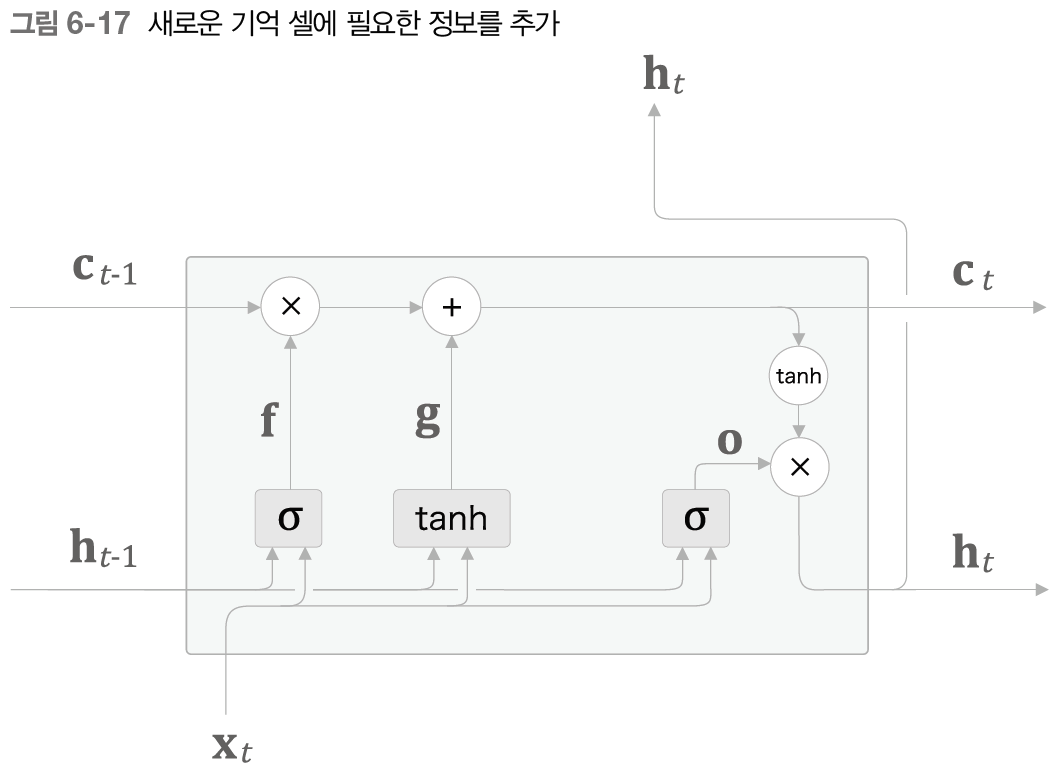

tanh 노드가 계산한 결과는 이전 시각의 기억 셀 $\mathbf{c_{t-1}}$에 더해진다. 즉 기억 셀에 새로운 '정보'가 추가되었다. 이 tanh 노드는 '게이트'가 아니고 새로운 '정보'를 기억 셀에 추가하는 것이 목적이다. 따라서 활성화 함수는 시그모이드 함수가 아닌 tanh 함수가 사용된다.

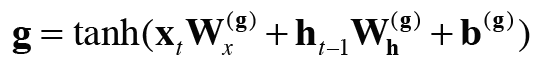

기억 샐에 추가하는 새로운 기억 $\mathbf g$는 이전 시각의 기억 셀 $\mathbf{c_{t-1}}$에 더해짐으로 새로운 기억이 생겨난다.
 
### 6.2.6 input 게이트
$\mathbf g$에 Input 게이트가 추가된다.

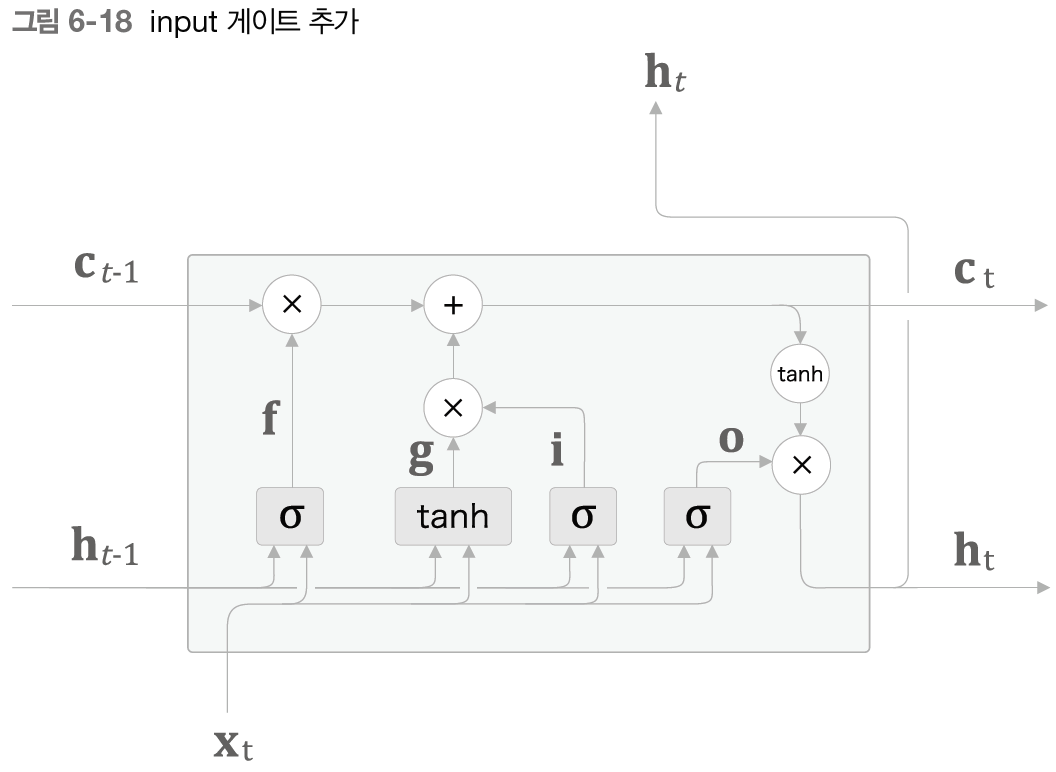

Input 게이트는 $\mathbf g$의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단한다. 다른 관점에서 보면 input 게이트에 의해 가중된 정보가 새로 추가된다. 

input 게이트를 $\mathbf{\sigma}$로, 그 출력을 $\mathbf i$로 표기한다. 

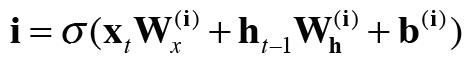

그 후 $\mathbf i$와 $\mathbf g$의 원소 곱 결과를 기억 셀에 추가한다. 

$$\mathbf c_t = \mathbf f \odot \mathbf {c_{t-1}} + \mathbf i \odot \mathbf g$$

> 지금까지의 LSTM이 대표적이지만 게이트 연결 방법이 약간 다른 계층도 있다.

### 6.2.7 LSTM의 기울기 흐름
LSTM의 구조가 어떤 원리로 기울기 소실을 없애주느냐는 기억 셀 $\mathbf c$의 역전파에 주목하면 된다.

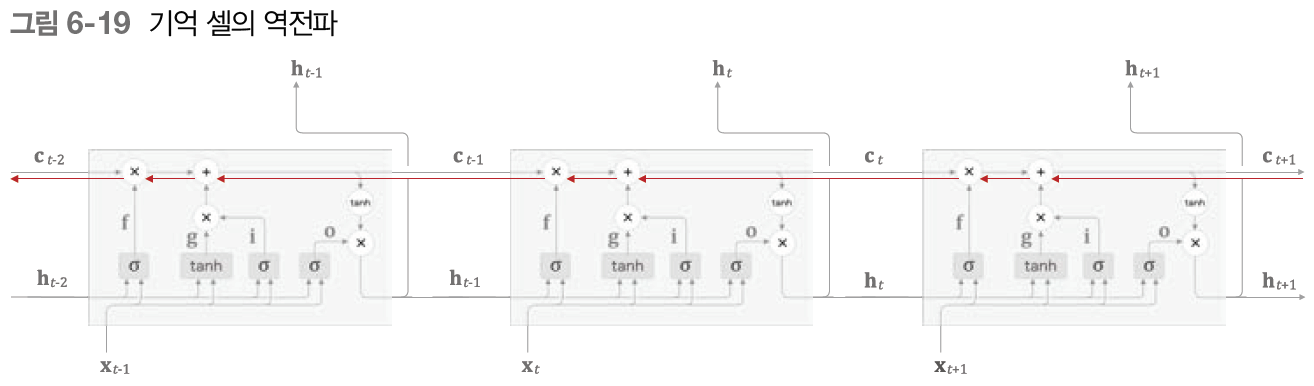

위의 그림은 기억 셀에만 집중해 역전파의 흐름을 그린 것이다. 기억 셀의 역전파에서는 '+'와 'X' 노드만 지난다. '+'노드는 상류에서 전해지는 기울기를 그대로 흘리므로 기울기 변화(감소)는 일어나지 않는다. 'X' 노드는 '원소별 곱(아마다르 곱)'을 계산하고, 매 시각 다른 게이트 값을 이용해 원소별 곱을 계산한다. 매번 새로운 게이트 값을 이용하므로 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나지 않는다. 

'X' 노드의 계산은 forget 게이트가 제어하며 매 시각 다른 게이트 값을 출력한다. forget 게이트가 잊어야 한다고 판단한 기억 셀의 원소에 대해서는 기울기가 작아지지만 잊어서는 안 된다고 판단한 원소에 대해서는 그 기울기가 약화되지 않은 채로 과거 방향으로 전해진다. 따라서 기억 셀의 기울기가 (오래 기억해야 할 정보일 경우) 소실 없이 전파된다. 이로 인해 기억 셀이 장기 의존 관계를 유지(학습)할 수 있다.